Expresiones sacadas de 
- Diapositivas de clase
- Cheat Sheet https://www.bogan.ca/orbits/kepler/orbteqtn.html
- Semi eje mayor https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Celestial_Mechanics_(Tatum)/10%3A_Computation_of_an_Ephemeris/10.06%3A_Elements_of_a_Hyperbolic_Orbit
- Hiperbolica https://control.asu.edu/Classes/MAE462/462Lecture05.pdf

In [42]:
import numpy as np
from scipy.optimize import root_scalar
from astropy import units as u
from astropy.time import Time
import matplotlib.pyplot as plt

# Simbolos y constantes 
"""
a = semieje mayor
e = excentricidad
omega = longitud del nodo ascendente
w = argumento del pericentro
i = inclinacion de la orbita
n = movimiento medio
lo = anomalia media en la epoca
tp = tiempo del perihelio
to = tiempo de la epoca
M = la suma de las masas de los cuerpos
GM = Parametro gravitacional del sol
"""

# Efemerides de la tierra
a_tierra = (1.495582533630905E+8*u.km).to('au')
ecc_tierra = 1.694863932474438E-02
omega_tierra = 1.498625963929686E+02*u.deg
w_tierra = 3.146587763491455E+02*u.deg
i_tierra = 4.164075603038432E-03*u.deg 
n_tierra = 1.141204629731537E-05*u.deg/u.s
l0_tierra = 1.817846947871890E+02*u.deg
GM_sol = 132712440041.93938*u.km**3/u.s**2
GM_sol = GM_sol.to("au**3/day**2")

#Transformacion de unidades
omega_tierra = omega_tierra.to('rad')
w_tierra = w_tierra.to('rad')
i_tierra = i_tierra.to('rad')
n_tierra = n_tierra.to('rad/s')
l0_tierra = l0_tierra.to('rad')

## Funciones de la Tierra
def Kepler_ellpitic(E, l, ecc):
    f = E - ecc*np.sin(E) - l
    fprime = 1 - ecc*np.cos(E)
    return f, fprime

def find_iota(t, l0, n, t0):
    return (l0 + n*(t-t0))

def find_f_elliptic(e, E):
    root_term = np.sqrt( (1+e)/(1-e) )
    right_side = root_term*np.tan(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_elliptic(a, ecc, E):
    return a*(1 - ecc*np.cos(E))

def find_xyz (r, Om, phi, i):
    x = r*(np.cos(Om)*np.cos(phi) - np.cos(i)*np.sin(Om)*np.sin(phi))
    y = r*(np.sin(Om)*np.cos(phi) + np.cos(i)*np.cos(Om)*np.sin(phi))
    z = r*(np.sin(i)*np.sin(phi))
    return (x, y, z)

def find_norm(vector):
    num = np.sqrt(vector[0].value**2 + vector[1].value**2 + vector[2].value**2)
    return num


##___________________________________________________________________________________________________________________________________________________________##
def Kepler_hyperbolic(E, l, ecc):
    f = ecc*np.sinh(E) - E - l
    fprime = ecc*np.cosh(E) - 1
    return f, fprime


## Funciones del cometa
def find_phi_cometa(xyz_vector, r_vector, inclinacion_vector):
    phi_vector = []
    for ii in range (len(xyz_vector)):
        inclinacion = inclinacion_vector
        #z = (xyz_vector[ii][2]*u.au).to('km')
        z = xyz_vector[ii][2]
        #inside = z.value / (r_vector[ii]*np.sin(inclinacion))
        inside = z / (r_vector[ii]*np.sin(inclinacion))
        if inside > 1:
            inside = 1*u.km/u.km
        phi = np.arcsin(inside)
        phi_vector.append(phi)
    return phi_vector
    
def find_velocidad():
    # Se usa el método del punto medio
    h = tiempos_cometa_inicial[1].utc- tiempos_cometa_inicial[0]
    velocidades_cometa_inicial = [0,0,0]

    for ii in range (3):
        velocidades_cometa_inicial[ii] = (coor_cometa_inicial[2][ii]*u.au - coor_cometa_inicial[0][ii]*u.au) / (2*h) 
    return velocidades_cometa_inicial

def find_inclination(xyz_vector, r_vector):
    inclinacion_vector = []
    for ii in range (len(xyz_vector)):
        xy0_vector = [xyz_vector[ii][0], xyz_vector[ii][1], 0]   
        dot_product = np.dot(xyz_vector[ii], xy0_vector)
        magnitud_r = r_vector[ii]
        magnitud_rz = np.linalg.norm(xy0_vector)
        inclinacion = np.arccos(dot_product/(magnitud_r*magnitud_rz))
        inclinacion_vector.append(inclinacion)
    return (inclinacion_vector)*u.rad

def find_f_hyperbolic(e, E):
    root_term = np.sqrt( (e+1)/(e-1) )
    right_side = root_term*np.tanh(E/2)
    f = 2*np.arctan(right_side)
    return f

def find_r_hyperbolic(a, ecc, E):
    return a*(1 - ecc*np.cosh(E))

def find_iota_hyperbolic(t, t0, l0, n):
    return (l0 + n*(t-t0))

##______________________________________________________________________________________##

## Parámetros temporales de la tierra
N_tiempos = (1*365)
t0 = Time('2023-07-09T00:00:00', scale='tdb', format = 'isot').utc
tf = Time('2024-07-09T00:00:00', scale='tdb', format = 'isot').utc
tiempos_evolucion = np.linspace(t0, tf, N_tiempos)

## Calculo orbita Tierra
plot_tierra_data = np.zeros((3, N_tiempos))
plot_cometa_data = np.zeros((3, N_tiempos))

for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_tierra = find_iota(t, l0_tierra, n_tierra, t0)


    ## 2. Solucionar la Ec. de Kepler
    # E_raiz_tierra = root_scalar(Kepler, args=(iota_tierra.value, ecc_tierra), bracket=[0, iota_tierra.value], method="brentq")
    E_raiz_tierra = root_scalar(Kepler_ellpitic, args=(iota_tierra.value, ecc_tierra), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_tierra = find_f_elliptic(ecc_tierra, E_raiz_tierra)
    #print(f_tierra)


    ## 4. Hallar phi
    phi_tierra = f_tierra + w_tierra


    ## 5. Hallar r
    r_tierra = find_r_elliptic(a_tierra, ecc_tierra, E_raiz_tierra)


    ## 6. Hallar x, y, z
    coor_tierra = find_xyz (r_tierra, omega_tierra, phi_tierra, i_tierra)
    for jj in range (3):
        plot_tierra_data[jj, ii] = coor_tierra[jj].value

##______________________________________________________________________________________##

## Parámetros temporales del cometa
tiempos_cometa_inicial = [
    Time('2023-07-09T10:00:00', scale='utc', format = 'isot'), Time('2023-07-09T12:00:00', scale='utc', format = 'isot'),
    Time('2023-07-09T14:00:00', scale='utc', format = 'isot'), Time('2023-08-03T11:00:00', scale='utc', format = 'isot'),
    Time('2023-08-15T08:00:00', scale='utc', format = 'isot'), Time('2023-08-21T09:00:00', scale='utc', format = 'isot')]

## Parámetros espaciales
coor_cometa_inicial = [
    [-136.5637561083746,  -58.86174117642695,  0.006477038631585696],
    [-136.52944516728272, -58.8582744676107,   0.006476657161271048],
    [-136.49508281581126, -58.85478559561711,  0.006476273252160792],
    [-123.8254221225029,  -56.75184521313076,  0.006244869528365741],
    [-115.92607005859432, -54.90754850330492,  0.0060419264825281455],
    [-111.38702385389293, -53.724113572894545, 0.0059117034614445335]]

## Hallamos vector r del cometa
r_cometa_inicial = [np.linalg.norm(coor_cometa_inicial[ii]) for ii in range (6)]

## Hallamos Velocidad v del cometa
velocidades_cometa_inicial = find_velocidad()
velocidades_cometa_inicial_valor = []

for ii in range (3):
    velocidades_cometa_inicial_valor.append(velocidades_cometa_inicial[ii].value)

## Hallamos momento angular L 
L_cometa =  np.cross(coor_cometa_inicial[1], velocidades_cometa_inicial_valor) #au**2/day

## Hallamos la excentricidad e
ecc_cometa_vector = np.cross(velocidades_cometa_inicial_valor, L_cometa) / GM_sol.value - coor_cometa_inicial[1]/r_cometa_inicial[1]
ecc_cometa = np.linalg.norm(ecc_cometa_vector)

## Hallamos el semilactus rectum P
P_cometa = ((np.linalg.norm(L_cometa)*u.au**2/u.day)**2) / GM_sol

## Hallamos Perihelio
perihelio_cometa = P_cometa / (1 + ecc_cometa)

## Hallamos el semieje mayor
aux_top = GM_sol*r_cometa_inicial[1]*u.au
aux_bot = 2*GM_sol - r_cometa_inicial[1]*u.au*np.linalg.norm(velocidades_cometa_inicial_valor)**2*(u.au/u.day)**2
a_cometa = aux_top / aux_bot ## Expresión de https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Celestial_Mechanics_(Tatum)/10%3A_Computation_of_an_Ephemeris/10.06%3A_Elements_of_a_Hyperbolic_Orbit


## Hallamos la energia especifica del sistema
energia_e_cometa = -GM_sol  / (2*a_cometa) ##energia > 0 orbita hiperbolica
energia_e_tierra = -GM_sol / (2*a_tierra) ## energia < 0 orbita eliptica

## hallamos el angulo de inclinacion de la orbita del cometa
i_cometa = np.arccos(L_cometa[2]/np.linalg.norm(L_cometa))*u.rad

## Hallamos la longitud del nodo ascendente omega
n = np.cross([0, 0, 1], L_cometa)
omega_cometa = np.arccos(n[0] / np.linalg.norm(n))*u.rad

## Hallamos el argumento del pericentro
w_cometa = np.arccos(np.dot(n , ecc_cometa_vector) / (np.linalg.norm(n) * ecc_cometa))*u.rad

# Compracion efemerides  cometa vs tierra
print('Comparacion efemerides cometa vs tierra')
print('Energias =', energia_e_cometa, energia_e_tierra)
print('semieje mayor  a =', a_cometa, a_tierra)
print('excentricidad e = ', ecc_cometa, ecc_tierra)
print('inclinacion i =', i_cometa, i_tierra)
print('nodo ascentente \u03A9 = ', omega_cometa, omega_tierra)
print('argumento del pericentro w =', w_cometa, w_tierra)

## Cálculo orbita cometa





Comparacion efemerides cometa vs tierra
Energias = 0.08575723158219534 AU2 / d2 -0.0001479952970772798 AU2 / d2
semieje mayor  a = -0.0017252901173819345 AU 0.9997351744598761 AU
excentricidad e =  25967.33465426792 0.01694863932474438
inclinacion i = 0.00011003817552377976 rad 7.267682957498903e-05 rad
nodo ascentente Ω =  3.141592653589793 rad 2.6155957326446804 rad
argumento del pericentro w = 1.671773906408136 rad 5.491831667589052 rad


In [49]:
def find_r_hyperbolic(a, ecc, f):
    top = a*(1 - ecc*2)
    bot = 1 + ecc*np.cos(f)
    return top/bot 


## Hallamos parámetros inicializadores
E_0_cometa = np.arccosh((1 - r_cometa_inicial[1]/a_cometa.value)/np.linalg.norm(ecc_cometa))*u.deg
l0_cometa = ecc_cometa*np.sinh(E_0_cometa)*u.deg - E_0_cometa
n_cometa = np.sqrt(-GM_sol/a_cometa**3)*u.deg
t0_cometa = tiempos_cometa_inicial[1]


for ii, t in enumerate(tiempos_evolucion):
    ## 1. Hallar iota
    iota_cometa = find_iota_hyperbolic(t, t0_cometa, l0_cometa, n_cometa)

    ## 2. Solucionar la Ec. de Kepler
    E_raiz_cometa = root_scalar(Kepler_hyperbolic, args=(iota_cometa.value, ecc_cometa), fprime = True, x0 = 0, xtol = 1E-8).root*u.rad


    ## 3. Hallar f
    f_cometa = find_f_hyperbolic(ecc_cometa, E_raiz_cometa)
    
    
    ## 4. Hallar phi
    phi_cometa = f_cometa + w_cometa


    ## 5. Hallar r
    #r_cometa = find_r_hyperbolic(a_cometa, ecc_cometa, E_raiz_cometa)
    r_cometa = find_r_hyperbolic(a_cometa, ecc_cometa, f_cometa)
    print(r_cometa, f_cometa)

    ## 6. Hallar x, y, z
    coor_cometa = find_xyz (r_cometa, omega_cometa, phi_cometa, i_cometa)
    for jj in range (3):
        plot_cometa_data[jj, ii] = coor_cometa[jj].value





0.003451726390157413 AU 0.027922629175753003 rad
0.003452770651248501 AU 0.037208235119262856 rad
0.003454112412341353 AU 0.04648742659351304 rad
0.0034557513269014573 AU 0.055758614293680286 rad
0.003457686972378676 AU 0.06502021715711222 rad
0.003459918850749886 AU 0.07427066396339516 rad
0.003462446389156342 AU 0.08350839490927159 rad
0.0034652689406338526 AU 0.09273186315452552 rad
0.0034683857849336403 AU 0.10193953633509006 rad
0.003471796129431441 AU 0.11112989803978626 rad
0.0034754991101222316 AU 0.12030144924726952 rad
0.0034794937926976867 AU 0.12945270971994385 rad
0.0034837791737032868 AU 0.1385822193518001 rad
0.0034883541817718098 AU 0.1476885394673403 rad
0.003493217678929724 AU 0.15677025406896827 rad
0.0034983684619728883 AU 0.16582597103045194 rad
0.003503805263907771 AU 0.17485432323429392 rad
0.0035095267554543165 AU 0.18385396965108716 rad
0.0035155315466064373 AU 0.19282359635917024 rad
0.003521818188246068 AU 0.20176191750314318 rad
0.0035283851738065956 AU 0.21

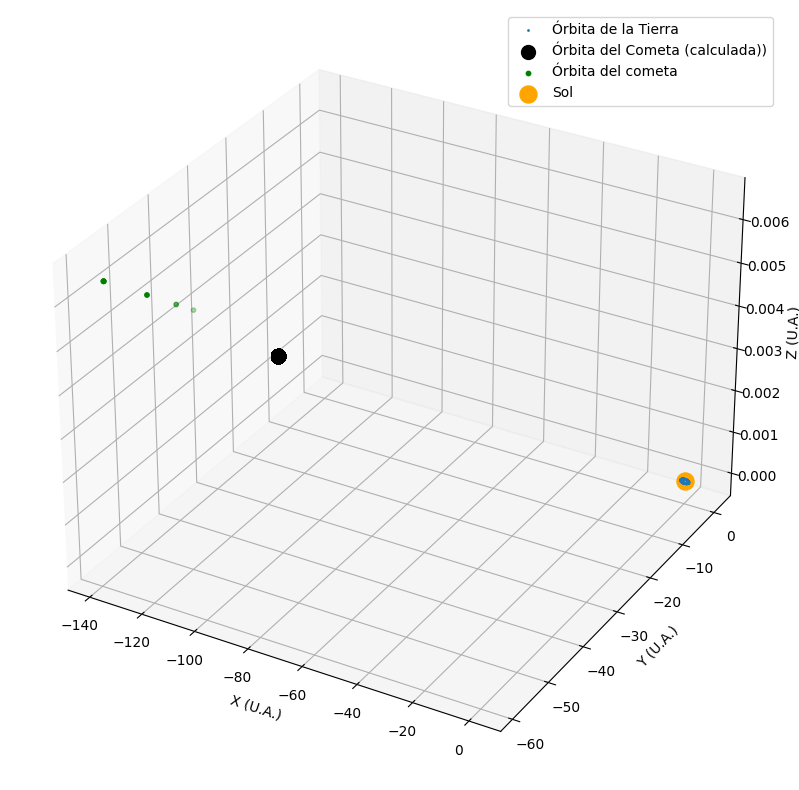

In [98]:
coor_cometa_inicial = np.transpose(coor_cometa_inicial)
## Plot de las ótbita
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.scatter(plot_tierra_data[0], plot_tierra_data[1], plot_tierra_data[2], label='Órbita de la Tierra', s=1)
ax.scatter(plot_cometa_data[0], plot_cometa_data[1], plot_cometa_data[2], label='Órbita del Cometa (calculada))', s=100, color="black")

ax.scatter(coor_cometa_inicial[0], coor_cometa_inicial[1], coor_cometa_inicial[2], label='Órbita del cometa', s=10, color="green")
ax.scatter(0, 0, 0, s=150, label='Sol', color="orange")

ax.legend()
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
#ax.set_zlim(-1, 1)
ax.set_xlabel('X (U.A.)')
ax.set_ylabel('Y (U.A.)')
ax.set_zlabel('Z (U.A.)')


plt.show()